In [38]:
from __future__ import print_function
%matplotlib inline
%pylab inline
# %load_ext memory_profiler
import matplotlib.pyplot as plt
import seaborn; seaborn.set_style('whitegrid')
import numpy
import itertools
from tabulate import tabulate
from pomegranate import *
from pomegranate import BayesianNetwork
import iac_org as iacO

import numpy as np

Populating the interactive namespace from numpy and matplotlib


/Users/pramitmallick/anaconda/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['dist']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [40]:
# !python iacO.py
attributes = ["gang", "age", "edu", "mar", "occ", "name"]

s = np.random.normal(0, 0.005, 1)
print(s[0],abs)

-0.00373914147639046


In [3]:
def prob(evidences, atts):
    count, total = 0, 0
    for datapoint in iacO.data:
        inc = True
        for key in evidences:
            inc = inc and datapoint[key] == evidences[key]
        if inc:
            total += 1
            f = True
            for key in atts:
                f = f and datapoint[key] == atts[key]
            if f:
                count += 1
    return count, total, float(count)/total

def enums(key):
    vals = set()
    for datapoint in iacO.data:
        if datapoint[key] not in vals:
            vals.add(datapoint[key])
    return list(vals)

In [5]:
print(prob({'gang': 'Jets', 'occ': 'pusher'},{'mar': 'single'}))
print(prob({},{'gang': 'Jets'}))
print(prob({},{'name': 'John'}))
print(prob({'name': 'John'},{'gang': 'Jets'}), prob({'name': 'John'},{'gang': 'Sharks'}))
print(len(iacO.data))
print(enums("name"), enums("edu"))

(4, 5, 0.8)
(15, 27, 0.5555555555555556)
(1, 27, 0.037037037037037035)
(1, 1, 1.0) (0, 1, 0.0)
27
['Pete', 'Ned', 'Jim', 'Ralph', 'Nick', 'Clyde', 'Rick', 'John', 'Lance', 'Ken', 'Mike', 'Fred', 'Dave', 'Ike', 'Earl', 'Ol', 'Don', 'Phil', 'Neal', 'Greg', 'Gene', 'Art', 'Sam', 'Al', 'Doug', 'George', 'Karl'] ['HS', 'JH', 'COL']


In [16]:
import collections
noisy_p_feature_given_hidden = {}
c = 0
for name in enums(attributes[-1]):
#     p1 = True if name == "George" else False
    noisy_p_feature_given_hidden[name] = {}
    for att in attributes[:-1]:
#         p2 = True if att == "edu" else False
        pl = 0.1/(len(enums(att))-1)
        for val in enums(att):
            noisy_p_feature_given_hidden[name][val] = 0.9 if prob({"name":name},{att:val})[2] == 1.0 else pl
            c += 1 if prob({"name":name},{att:val})[2] == 1 else 0
#             if p1 and p2:
#                 print(prob({"name":name},{att:val})[2], pl, name, att, val)
#                 print(prob({"name":name},{att:val})[2] == 1)
            
print(prob({"name":"George"},{"edu":"JH"})[2], prob({"name":"George"},{"edu":"COL"})[2], prob({"name":"George"},{"edu":"HS"})[2])
print(c/27, noisy_p_feature_given_hidden["George"]["JH"], noisy_p_feature_given_hidden["George"]["COL"], noisy_p_feature_given_hidden["George"]["HS"])

1.0 0.0 0.0
5 0.9 0.05 0.05


In [10]:
enums("edu")

['HS', 'JH', 'COL']

In [18]:
# attributes = ["gang", "age", "edu", "mar", "occ"]
attributes = ["gang", "age", "edu", "mar", "occ", "name"]
distributions = {}
for att in attributes:
    probs = {}
    vals = enums(att)
    for val in vals:
        probs[val] = prob({},{att:val})[2]
    distributions[att] = DiscreteDistribution(probs)

dataInArray = []
n = {}
for datapoint in iacO.data:
    row = []
    for att in attributes:
        row.append(datapoint[att])
#     row.append(datapoint["name"])
    dataInArray.append(row)
#     n[tuple(row)] = datapoint["name"]
print(len(dataInArray))
# print(tabulate(dataInArray))

27


((2,), (0,), (), (), (), ())


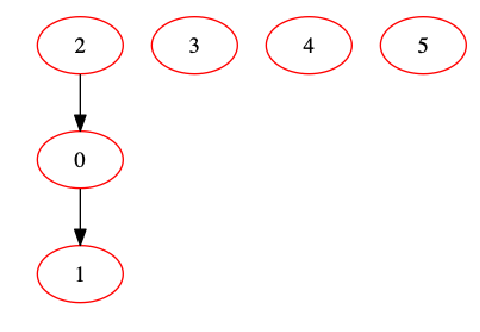

In [19]:
modelFromData = BayesianNetwork.from_samples(dataInArray, algorithm='exact')
print(modelFromData.structure)
modelFromData.plot()

In [21]:
src = []
dist = []
states = []
for att in attributes:
    src.append(enums(att))
    dist.append(distributions[att])
CPT = []
cpt_dict = {}
c = 0
for element in itertools.product(*src):
    temp = list(element)
    if temp in dataInArray:
        CPT.append(temp+[1])
        c += 1
        cpt_dict[element] = 1
    else:
        CPT.append(temp+[0])
        cpt_dict[element] = 0
# CPT
# print(cpt_dict)
# print(tabulate(CPT, headers=attributes+["prob"]))

In [36]:
# p(h|e) = p(h)p(envidence|hyp)/sum(p(h)p(envidence|hyp))
# noisy_p_feature_given_hidden["George"]["JH"]
Noisy_CPT = []
d_evidence = {}
for element in itertools.product(*src):
    name = element[-1]
    evidences = element[:-1]
#     print(evidences, name)
    if evidences not in d_evidence:
        d_evidence[evidences] = {}
    if name not in d_evidence[evidences]:
        d_evidence[evidences][name] = 1
    for evi in evidences:
#         print(evi)
        d_evidence[evidences][name] *= noisy_p_feature_given_hidden[name][evi]
    
eq_evidence = {}
for element in itertools.product(*src[:-1]):
#     print(element)
    evidences = element
    eq_evidence[evidences] = 0
    for name in enums("name"):
        eq_evidence[evidences] += d_evidence[evidences][name]

        
# evis = ('Jets', '20s', 'HS', 'married', 'pusher')
# print(d_evidence[evis])

c = 0
for element in itertools.product(*src):
    name = element[-1]
    evidences = element[:-1]
    temp = list(element)
    normalized_noisy_prob = d_evidence[evidences][name]/eq_evidence[evidences]
#     Noisy_CPT.append(temp+[normalized_noisy_prob])
    if temp in dataInArray:
        Noisy_CPT.append(temp+[normalized_noisy_prob]+[1])
        c += 1
    else:
        Noisy_CPT.append(temp+[normalized_noisy_prob]+[0])


In [37]:
# print(tabulate(CPT, headers=attributes+["prob"]))
print(tabulate(Noisy_CPT, headers=attributes+["noisy prob", "actual"]))

gang    age    edu    mar       occ      name      noisy prob    actual
------  -----  -----  --------  -------  ------  ------------  --------
Jets    20s    HS     single    bookie   Pete     0.837869            1
Jets    20s    HS     single    bookie   Ned      1.59631e-05         0
Jets    20s    HS     single    bookie   Jim      0.000143667         0
Jets    20s    HS     single    bookie   Ralph    0.000143667         0
Jets    20s    HS     single    bookie   Nick     0.000287335         0
Jets    20s    HS     single    bookie   Clyde    0.00258601          0
Jets    20s    HS     single    bookie   Rick     1.59631e-05         0
Jets    20s    HS     single    bookie   John     0.000143667         0
Jets    20s    HS     single    bookie   Lance    0.000143667         0
Jets    20s    HS     single    bookie   Ken      0.00517203          0
Jets    20s    HS     single    bookie   Mike     0.00258601          0
Jets    20s    HS     single    bookie   Fred     0.0465483     

In [8]:
cond = ConditionalProbabilityTable(CPT, dist[:-1])
name = State(cond, name="name")
gang = State(distributions["gang"], name="gang")
age = State(distributions["age"], name="age")
edu = State(distributions["edu"], name="edu")
mar = State(distributions["mar"], name="mar")
occ = State(distributions["occ"], name="occ")

model = BayesianNetwork("Jets and Sharks")
model.add_states(gang, age, edu, mar, occ, name)

model.add_edge(gang, name)
model.add_edge(age, name)
model.add_edge(edu, name)
model.add_edge(mar, name)
model.add_edge(occ, name)
model.bake()
# print(model.predict_proba({}))

In [12]:
# print(prob({'gang': 'Jets', 'occ': 'pusher'},{'mar': 'single'}))
# print(model.predict_proba({'occ': 'bookie' ,'mar': 'single'}))
# print(prob({'name': 'Lance', 'occ': 'pusher'},{'mar': 'single'}))
# print(model.predict_proba({'name': 'Lance', 'occ': 'pusher'}))
# print(model.predict_proba({'gang': 'Sharks', 'age': '20s'}))
print(model.predict_proba({'gang': 'Jets'}))
# print(model.predict_proba({'name': 'John'}))
# print(prob({},{'gang': 'Jets'}))
# print(prob({},{'name': 'John'x}))

['Jets'
 {
    "frozen" :false,
    "dtype" :"str",
    "class" :"Distribution",
    "parameters" :[
        {
            "20s" :0.5081771601038815,
            "30s" :0.42612479820313043,
            "40s" :0.06569804169298818
        }
    ],
    "name" :"DiscreteDistribution"
}
 {
    "frozen" :false,
    "dtype" :"str",
    "class" :"Distribution",
    "parameters" :[
        {
            "HS" :0.4084368639011721,
            "JH" :0.47504737839545147,
            "COL" :0.10949673615498019,
            "JS" :0.00701902154839625
        }
    ],
    "name" :"DiscreteDistribution"
}
 {
    "frozen" :false,
    "dtype" :"str",
    "class" :"Distribution",
    "parameters" :[
        {
            "single" :0.7199410402189932,
            "married" :0.22952200463255432,
            "divorced" :0.05053695514845243
        }
    ],
    "name" :"DiscreteDistribution"
}
 {
    "frozen" :false,
    "dtype" :"str",
    "class" :"Distribution",
    "parameters" :[
        {
            "pu

In [10]:
print(model.predict_proba({'occ': 'pusher'}))

[{
    "frozen" :false,
    "dtype" :"str",
    "class" :"Distribution",
    "parameters" :[
        {
            "Jets" :0.6240137544454651,
            "Sharks" :0.37598624555453497
        }
    ],
    "name" :"DiscreteDistribution"
}
 {
    "frozen" :false,
    "dtype" :"str",
    "class" :"Distribution",
    "parameters" :[
        {
            "20s" :0.38978779528486274,
            "30s" :0.5551002143244071,
            "40s" :0.055111990390730045
        }
    ],
    "name" :"DiscreteDistribution"
}
 {
    "frozen" :false,
    "dtype" :"str",
    "class" :"Distribution",
    "parameters" :[
        {
            "HS" :0.5269554158129017,
            "JH" :0.23422595916060174,
            "COL" :0.23881862502649648,
            "JS" :0.0
        }
    ],
    "name" :"DiscreteDistribution"
}
 {
    "frozen" :false,
    "dtype" :"str",
    "class" :"Distribution",
    "parameters" :[
        {
            "single" :0.6696106832473678,
            "married" :0.27650203725947375,
